<a href="https://colab.research.google.com/github/magistery-tps/dm-cyt-tp2/blob/main/notebooks/create_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####  Referencias

* [Pandas pipelines](https://calmcode.io/pandas-pipe/end.html)
* [Python logger](https://www.youtube.com/watch?v=g8nQ90Hk328&list=PLi01XoE8jYohWFPpC17Z-wWhPOSuh8Er-&index=17)
* [Dataset](https://smallworldofwords.org/en/project/research)
* [Glove word embedding](https://nlp.stanford.edu/projects/glove/)
* [Elmo word embedding](https://allennlp.org/elmo)
* [Basics of Using Pre-trained GloVe Vectors in Python](https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db)

In [1]:
from IPython.display import clear_output
import sys
import os.path
from os import path

def is_runing_into_colab_env():
    try:
        import google.colab
        return True
    except:
        return False

### 1. Instalacion de paquetes

Bajo paquete para trabajar con EEG- Me permite ver la topografía

In [2]:
if is_runing_into_colab_env(): 
    !pip install rich

In [3]:
%matplotlib inline
%load_ext autoreload
%load_ext rich
%autoreload 2

###  2. Descargar dataset

Se descarga el dataset y lo descomprime en `~/datasets`.

In [4]:
dataset_filename = "strength.SWOW-EN.R1.csv"
embeding_filename = "glove.840B.300d"
embeding_filename_txt = embeding_filename + '.txt'

dataset_url  = 'https://raw.githubusercontent.com/magistery-tps/dm-cyt-tp2/main/datasets/{}.zip'.format(dataset_filename)
embeding_url = 'https://nlp.stanford.edu/data/{}.zip'.format(embeding_filename)

if is_runing_into_colab_env():
    !cd ~
    !rm -rf datasets
    !rm -rf *.zip
    !wget  {dataset_url}
    !wget  {embeding_url}
    !unzip {dataset_filename}.zip
    !unzip {embeding_filename}.zip
    !mkdir datasets
    !mv {dataset_filename} datasets
    !mv {embeding_filename}.txt datasets
    !rm *.zip

###  3. Importa libreria del proyecto

In [5]:
if is_runing_into_colab_env():
    if path.exists('/content/dm-cyt-tp2'):
        print('Pull...\n')
        !cd dm-cyt-tp2; git pull origin main
    else:
        print('Clone...\n')
        !git clone https://github.com/magistery-tps/dm-cyt-tp2.git

In [6]:
sys.path.append('/content/dm-cyt-tp2/src' if is_runing_into_colab_env() else '../src')
dataset_path = '/content/datasets/{}' if is_runing_into_colab_env() else '../datasets/{}'

###  4. Importa paquetes externos

In [7]:
import numpy as np
import pandas as pd

import logging
from logger import setup_logger

from scipy.spatial.distance import euclidean, jaccard, cosine
from distance import closest, show_closest

from transform_step import  select_columns, \
                            rename_columns, \
                            filter_bidiredtional_associations, \
                            filter_words_lt, \
                            filter_stopwords, \
                            to_unique_works, \
                            to_work_embeddings, \
                            lower, \
                            strip, \
                            dropna

from output_step import plot_frequency, \
                        log_unique_words, \
                        log_source_into_response_and_vise_versa

[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
setup_logger(format = '%(levelname)s: %(message)s')

###  5. Preprocesar dataset

In [9]:
def dataset(filename): return pd.read_csv(dataset_path.format(filename), sep='\t')

INFO: (483636, 5) --> select_columns({}) --> (483636, 2)
INFO: (483636, 2) --> rename_columns({}) --> (483636, 2)
INFO: (483636, 2) --> lower({}) --> (483636, 2)
INFO: (483636, 2) --> strip({}) --> (483636, 2)
INFO: Unique - Source: 12217, Response: 63530
INFO: Unique: True, Source into response: 388907, Response into source: 482447
INFO: Unique: False, Source into response: 94729, Response into source: 1189
INFO: (483636, 2) --> filter_words_lt({'size_less_than': 2}) --> (482247, 2)
INFO: (482247, 2) --> dropna({}) --> (482200, 2)
INFO: (482200, 2) --> filter_bidiredtional_associations({}) --> (386910, 2)
INFO: (386910, 2) --> filter_stopwords({'languages': ['arabic']}) --> (386910, 2)
INFO: (386910, 2) --> filter_stopwords({'languages': ['azerbaijani']}) --> (386733, 2)
INFO: (386733, 2) --> filter_stopwords({'languages': ['bengali']}) --> (386733, 2)
INFO: (386733, 2) --> filter_stopwords({'languages': ['danish']}) --> (386222, 2)
INFO: (386222, 2) --> filter_stopwords({'languages':

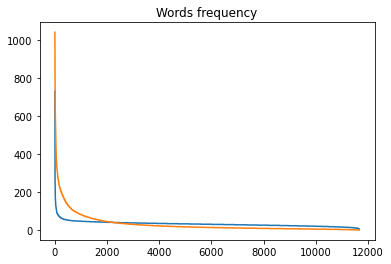

In [10]:
output = \
    dataset(dataset_filename) \
    .pipe(select_columns) \
    .pipe(rename_columns) \
    .pipe(lower) \
    .pipe(strip) \
    .pipe(log_unique_words) \
    .pipe(log_source_into_response_and_vise_versa, unique=True) \
    .pipe(log_source_into_response_and_vise_versa, unique=False) \
    .pipe(filter_words_lt, size_less_than=2) \
    .pipe(dropna) \
    .pipe(filter_bidiredtional_associations) \
    .pipe(filter_stopwords, column = 'source') \
    .pipe(filter_stopwords, column = 'response') \
    .pipe(plot_frequency, column = 'source') \
    .pipe(plot_frequency, column = 'response')

###  6. Generar un dicionario de embedding a partir de Glove

In [11]:
work_embeddings = output \
    .pipe(to_unique_works) \
    .pipe(to_work_embeddings, file_path = dataset_path.format(embeding_filename_txt))

INFO: (367594, 2) --> to_unique_works({}) --> (367201, 1)


  0%|          | 0/367201 [00:00<?, ?it/s]

INFO: Found 5319 words.
INFO: (367201, 1) --> to_work_embeddings({'file_path': '../datasets/glove.840B.300d.txt'}) --> 5319


### 7. Calcular distancias

In [12]:
any_word = list(work_embeddings.keys())[10]

show_closest(work_embeddings, any_word, cosine)
show_closest(work_embeddings, any_word, euclidean)
show_closest(work_embeddings, any_word, jaccard)

INFO: - distance: cosine
INFO: - Word: alternative
INFO: - Closest: ['preferable', 'affordable', 'straightforward', 'mainstream', 'sustainable', 'regardless', 'marketplace', 'framework', 'guidelines']
INFO: - distance: euclidean
INFO: - Word: alternative
INFO: - Closest: ['preferable', 'straightforward', 'regardless', 'affordable', 'mainstream', 'mainstay', 'drawback', 'forefront', 'alongside']
INFO: - distance: jaccard
INFO: - Word: alternative
INFO: - Closest: ['jetliner', 'dealbreaker', 'goldeneye', 'shipmate', 'penknife', 'masterbedroom', 'stairstep', 'serverfarm', 'website']
